# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>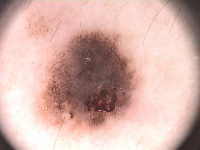</td><td>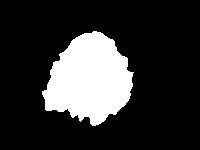</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [1]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-05-27 18:02:08--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-05-27 18:02:09--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7b5f9ccc7a09eb493af76001df.dl.dropboxusercontent.com/cd/0/inline/A4iujw7R2V-viWtr1XTBGMZ5uvNlZqS7KTzP9GBXzPXJncX-aOMLFqrMeomSgJA1Fc_BIR7Rdc-SDttmQuBg7jOdNJ5AcU6Si1kXY0FBaZbz9Q/file# [following]
--2020-05-27 18:02:09--  https://uc7b5f9ccc7a09eb493af76001df.dl.dropboxusercontent.com/cd/0/inline/A4iujw7R2V-viWtr1XTBGMZ5uvNlZqS7KTzP9GBXzPXJncX-aOMLFqrMeomSgJA1Fc_BIR7Rdc-SDttmQuBg7jOdNJ5AcU6Si1kXY0FBaZbz9Q/file
Resolving u

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

###Раздел для дальнейшего сравнения:

In [0]:
segnet_bce_loss = []
segnet_bce_acc = []
unet_bce_loss = []
unet_bce_acc = []
unet2_bce_loss = []
unet2_bce_acc = []

segnet_dice_loss = []
segnet_dice_acc = []
unet_dice_loss = []
unet_dice_acc = []
unet2_dice_loss = []
unet2_dice_acc = []

segnet_focal_loss = []
segnet_focal_acc = []
unet_focal_loss = []
unet_focal_acc = []
unet2_focal_loss = []
unet2_focal_acc = []

segnet_focal_loss = []
segnet_focal_acc = []
unet_focal_loss = []
unet_focal_acc = []
unet2_focal_loss = []
unet2_focal_acc = []

segnet_tversky_loss = []
segnet_tversky_acc = []
unet_tversky_loss = []
unet_tversky_acc = []
unet2_tversky_loss = []
unet2_tversky_acc = []

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

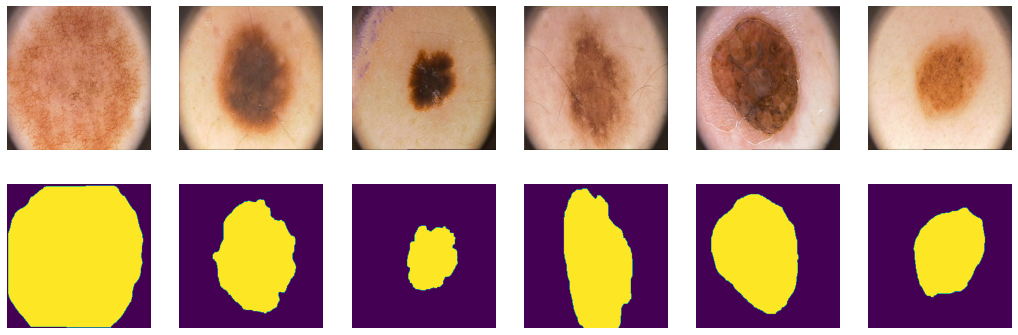

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
Y[1].shape

(256, 256)

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

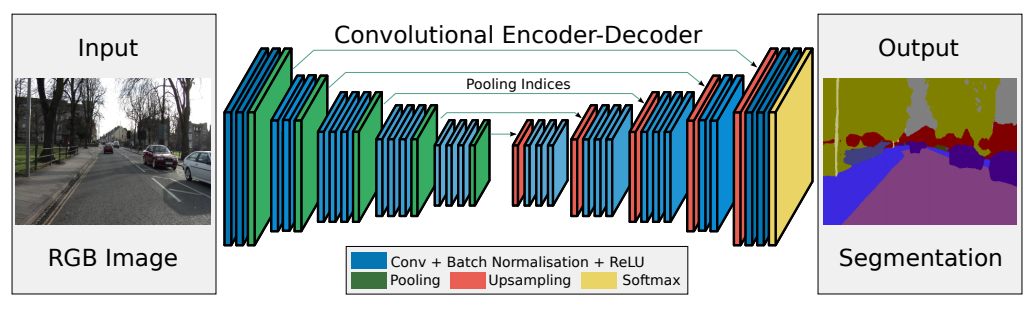

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16 ////18

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.upsample1 =  nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)# 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x.to(device))))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Поскольку сумма выглядит достаточно большой и непохожей на привычный лосс, то заменю средним значением.

In [0]:
def bce_loss(y_real, y_pred):
  #loss = nn.BCELoss()
  #return loss(y_pred, y_real)
  return torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))
    # TODO 
    # please don't use nn.BCELoss. write it from scratch

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, loss_arch):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            # set parameter gradients to zero

            # forward
            Y_pred = model(X_batch).to(device)
        
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        scheduler.step()
        # show intermediate results
        model.eval()  # testing mode
        if(epoch % 20 == 0):
          if(loss_arch == 1):
            segnet_bce_loss.append(avg_loss)
            segnet_bce_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 2):
            unet_bce_loss.append(avg_loss)
            unet_bce_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 3):
            unet2_bce_loss.append(avg_loss)
            unet2_bce_acc.append(score_model(model, iou_pytorch, data_val))
          
          if(loss_arch == 4):
            segnet_dice_loss.append(avg_loss)
            segnet_dice_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 5):
            unet_dice_loss.append(avg_loss)
            unet_dice_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 6):
            unet2_dice_loss.append(avg_loss)  
            unet2_dice_acc.append(score_model(model, iou_pytorch, data_val))

          if(loss_arch == 7):
            segnet_focal_loss.append(avg_loss)
            segnet_focal_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 8):
            unet_focal_loss.append(avg_loss)
            unet_focal_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 9):
            unet2_focal_loss.append(avg_loss)
            unet2_focal_acc.append(score_model(model, iou_pytorch, data_val))

          if(loss_arch == 10):
            segnet_tversky_loss.append(avg_loss)
            segnet_tversky_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 11):
            unet_tversky_loss.append(avg_loss)
            unet_tversky_acc.append(score_model(model, iou_pytorch, data_val))
          if(loss_arch == 12):
            unet2_tversky_loss.append(avg_loss) 
            unet2_tversky_acc.append(score_model(model, iou_pytorch, data_val))
          with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu().detach().numpy() > 0.5# detach and put into cpu

            # Visualize tools
            clear_output(wait=True)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch)
        scores += metric(Y_pred.to('cpu') > 0.5, Y_label.to('cpu')).mean().item()

    return scores/len(data)

## Основной момент: обучение

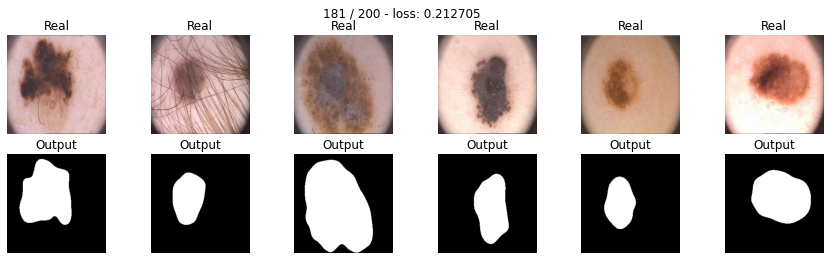

* Epoch 182/200
loss: 0.212705
* Epoch 183/200
loss: 0.212705
* Epoch 184/200
loss: 0.212705
* Epoch 185/200
loss: 0.212705
* Epoch 186/200
loss: 0.212705
* Epoch 187/200
loss: 0.212705
* Epoch 188/200
loss: 0.212705
* Epoch 189/200
loss: 0.212705
* Epoch 190/200
loss: 0.212705
* Epoch 191/200
loss: 0.212705
* Epoch 192/200
loss: 0.212705
* Epoch 193/200
loss: 0.212705
* Epoch 194/200
loss: 0.212705
* Epoch 195/200
loss: 0.212705
* Epoch 196/200
loss: 0.212705
* Epoch 197/200
loss: 0.212705
* Epoch 198/200
loss: 0.212705
* Epoch 199/200
loss: 0.212705
* Epoch 200/200
loss: 0.212705


In [89]:
segnet_bce_acc = []
segnet_bce_loss = []
model = SegNet().to(device)
max_epochs = 200
optim = torch.optim.Adam(model.parameters(), lr = 3e-4)#288-144-72-36-18
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
train(model, optim, bce_loss, max_epochs, data_tr, data_val, 1)

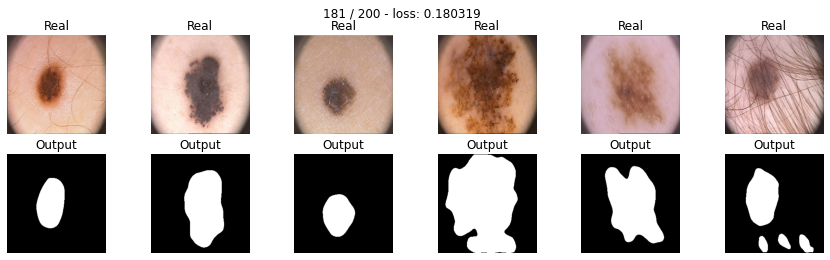

* Epoch 182/200
loss: 0.180319
* Epoch 183/200
loss: 0.180319
* Epoch 184/200
loss: 0.180319
* Epoch 185/200
loss: 0.180319
* Epoch 186/200
loss: 0.180319
* Epoch 187/200
loss: 0.180319
* Epoch 188/200
loss: 0.180319
* Epoch 189/200
loss: 0.180319
* Epoch 190/200
loss: 0.180319
* Epoch 191/200
loss: 0.180319
* Epoch 192/200
loss: 0.180319
* Epoch 193/200
loss: 0.180319
* Epoch 194/200
loss: 0.180319
* Epoch 195/200
loss: 0.180319
* Epoch 196/200
loss: 0.180319
* Epoch 197/200
loss: 0.180319
* Epoch 198/200
loss: 0.180319
* Epoch 199/200
loss: 0.180319
* Epoch 200/200
loss: 0.180319


In [90]:
unet_bce_acc = []
unet_bce_loss = []
model = UNet().to(device)
max_epochs = 200
optim = torch.optim.Adam(model.parameters(), lr = 3e-4)#288-144-72-36-18
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
train(model, optim, bce_loss, max_epochs, data_tr, data_val, 2)

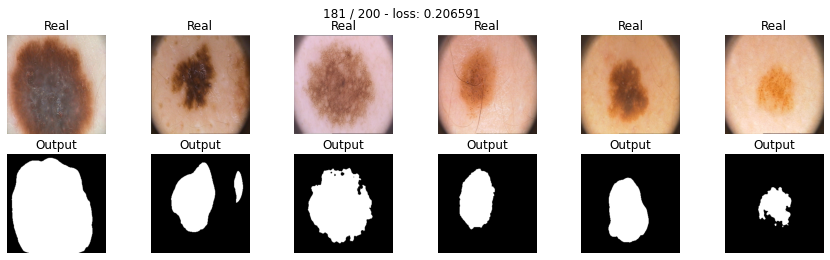

* Epoch 182/200
loss: 0.206591
* Epoch 183/200
loss: 0.206591
* Epoch 184/200
loss: 0.206591
* Epoch 185/200
loss: 0.206591
* Epoch 186/200
loss: 0.206591
* Epoch 187/200
loss: 0.206591
* Epoch 188/200
loss: 0.206591
* Epoch 189/200
loss: 0.206591
* Epoch 190/200
loss: 0.206591
* Epoch 191/200
loss: 0.206591
* Epoch 192/200
loss: 0.206591
* Epoch 193/200
loss: 0.206591
* Epoch 194/200
loss: 0.206591
* Epoch 195/200
loss: 0.206591
* Epoch 196/200
loss: 0.206591
* Epoch 197/200
loss: 0.206591
* Epoch 198/200
loss: 0.206591
* Epoch 199/200
loss: 0.206591
* Epoch 200/200
loss: 0.206591


In [91]:
unet2_bce_acc = []
unet2_bce_loss = []
model = UNet2().to(device)
max_epochs = 200
optim = torch.optim.Adam(model.parameters(), lr = 3e-4)#288-144-72-36-18
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)
train(model, optim, bce_loss, max_epochs, data_tr, data_val, 3)

In [32]:

score_model(model, iou_pytorch,data_val)

0.5320000052452087

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred): #torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))
    y_pred = torch.sigmoid(y_pred)
    num =  torch.sum(2 * (y_real * y_pred), dim=(2,3))
    den = torch.sum((y_real ** 2 + y_pred ** 2), dim=(2,3))
    res = 1 - (num + 0.00001) / (den + 0.00001)
    return torch.mean(res) 

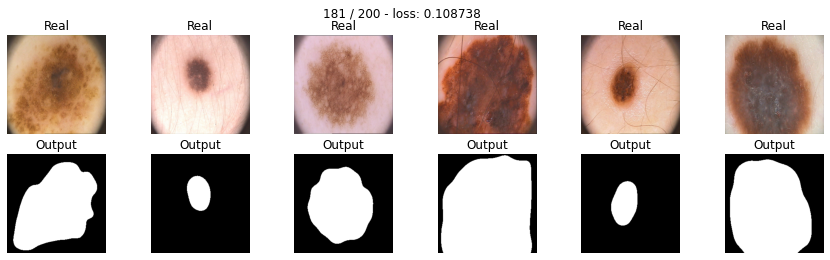

* Epoch 182/200
loss: 0.108738
* Epoch 183/200
loss: 0.108738
* Epoch 184/200
loss: 0.108738
* Epoch 185/200
loss: 0.108738
* Epoch 186/200
loss: 0.108738
* Epoch 187/200
loss: 0.108738
* Epoch 188/200
loss: 0.108738
* Epoch 189/200
loss: 0.108738
* Epoch 190/200
loss: 0.108738
* Epoch 191/200
loss: 0.108738
* Epoch 192/200
loss: 0.108738
* Epoch 193/200
loss: 0.108738
* Epoch 194/200
loss: 0.108738
* Epoch 195/200
loss: 0.108738
* Epoch 196/200
loss: 0.108738
* Epoch 197/200
loss: 0.108738
* Epoch 198/200
loss: 0.108738
* Epoch 199/200
loss: 0.108738
* Epoch 200/200
loss: 0.108738


In [33]:
model_dice = SegNet().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, 4)

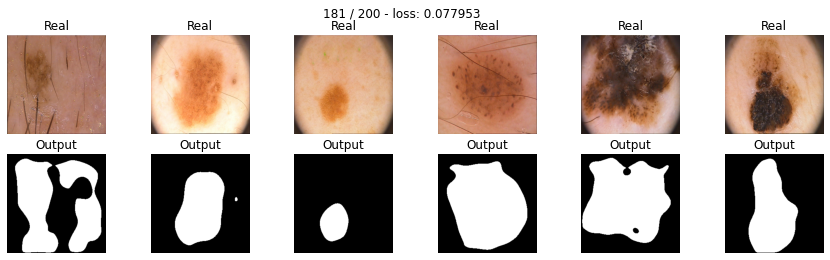

* Epoch 182/200
loss: 0.077953
* Epoch 183/200
loss: 0.077953
* Epoch 184/200
loss: 0.077953
* Epoch 185/200
loss: 0.077953
* Epoch 186/200
loss: 0.077953
* Epoch 187/200
loss: 0.077953
* Epoch 188/200
loss: 0.077953
* Epoch 189/200
loss: 0.077953
* Epoch 190/200
loss: 0.077953
* Epoch 191/200
loss: 0.077953
* Epoch 192/200
loss: 0.077953
* Epoch 193/200
loss: 0.077953
* Epoch 194/200
loss: 0.077953
* Epoch 195/200
loss: 0.077953
* Epoch 196/200
loss: 0.077953
* Epoch 197/200
loss: 0.077953
* Epoch 198/200
loss: 0.077953
* Epoch 199/200
loss: 0.077953
* Epoch 200/200
loss: 0.077953


In [34]:
model_dice = UNet().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, 5)

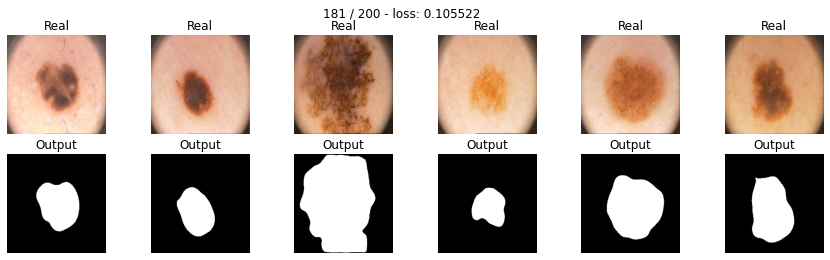

* Epoch 182/200
loss: 0.105522
* Epoch 183/200
loss: 0.105522
* Epoch 184/200
loss: 0.105522
* Epoch 185/200
loss: 0.105522
* Epoch 186/200
loss: 0.105522
* Epoch 187/200
loss: 0.105522
* Epoch 188/200
loss: 0.105522
* Epoch 189/200
loss: 0.105522
* Epoch 190/200
loss: 0.105522
* Epoch 191/200
loss: 0.105522
* Epoch 192/200
loss: 0.105522
* Epoch 193/200
loss: 0.105522
* Epoch 194/200
loss: 0.105522
* Epoch 195/200
loss: 0.105522
* Epoch 196/200
loss: 0.105522
* Epoch 197/200
loss: 0.105522
* Epoch 198/200
loss: 0.105522
* Epoch 199/200
loss: 0.105522
* Epoch 200/200
loss: 0.105522


In [35]:
model_dice = UNet2().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, 6)

Проводим тестирование:

In [0]:
score_model(model_dice, iou_pytorch, data_val)

0.6239999532699585

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), eps, 1 - eps)
    return torch.mean( - torch.mean((1 - y_pred) ** gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred), dim=(2,3)), dim=(0,1))


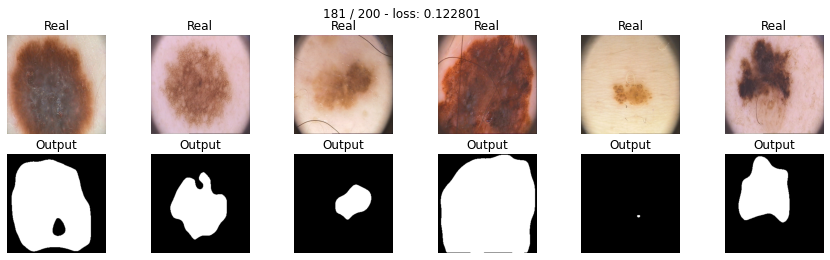

* Epoch 182/200
loss: 0.122801
* Epoch 183/200
loss: 0.122800
* Epoch 184/200
loss: 0.122800
* Epoch 185/200
loss: 0.122800
* Epoch 186/200
loss: 0.122800
* Epoch 187/200
loss: 0.122800
* Epoch 188/200
loss: 0.122800
* Epoch 189/200
loss: 0.122800
* Epoch 190/200
loss: 0.122800
* Epoch 191/200
loss: 0.122800
* Epoch 192/200
loss: 0.122800
* Epoch 193/200
loss: 0.122800
* Epoch 194/200
loss: 0.122800
* Epoch 195/200
loss: 0.122800
* Epoch 196/200
loss: 0.122800
* Epoch 197/200
loss: 0.122800
* Epoch 198/200
loss: 0.122800
* Epoch 199/200
loss: 0.122800
* Epoch 200/200
loss: 0.122800


In [36]:
model_focal = SegNet().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_focal.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, 7)

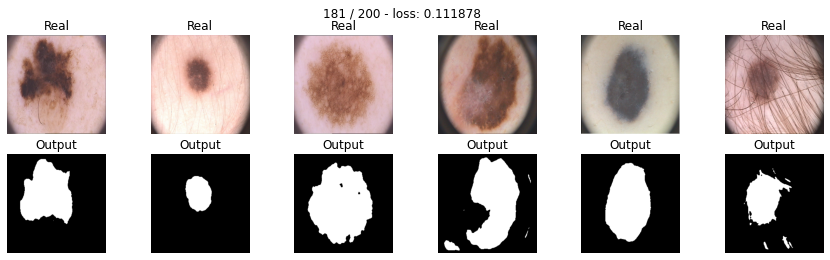

* Epoch 182/200
loss: 0.111878
* Epoch 183/200
loss: 0.111878
* Epoch 184/200
loss: 0.111878
* Epoch 185/200
loss: 0.111878
* Epoch 186/200
loss: 0.111877
* Epoch 187/200
loss: 0.111877
* Epoch 188/200
loss: 0.111877
* Epoch 189/200
loss: 0.111877
* Epoch 190/200
loss: 0.111877
* Epoch 191/200
loss: 0.111876
* Epoch 192/200
loss: 0.111876
* Epoch 193/200
loss: 0.111876
* Epoch 194/200
loss: 0.111876
* Epoch 195/200
loss: 0.111876
* Epoch 196/200
loss: 0.111876
* Epoch 197/200
loss: 0.111876
* Epoch 198/200
loss: 0.111876
* Epoch 199/200
loss: 0.111876
* Epoch 200/200
loss: 0.111876


In [37]:
model_focal = UNet().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_focal.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, 8)

In [0]:
unet2_focal_acc = []
unet2_focal_loss = []

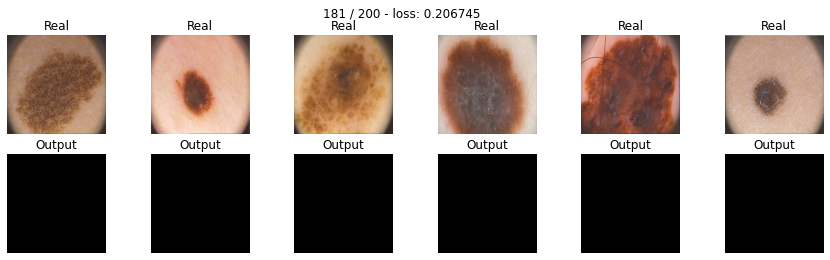

* Epoch 182/200
loss: 0.206745
* Epoch 183/200
loss: 0.206745
* Epoch 184/200
loss: 0.206745
* Epoch 185/200
loss: 0.206744
* Epoch 186/200
loss: 0.206744
* Epoch 187/200
loss: 0.206744
* Epoch 188/200
loss: 0.206744
* Epoch 189/200
loss: 0.206744
* Epoch 190/200
loss: 0.206744
* Epoch 191/200
loss: 0.206744
* Epoch 192/200
loss: 0.206743
* Epoch 193/200
loss: 0.206743
* Epoch 194/200
loss: 0.206744
* Epoch 195/200
loss: 0.206743
* Epoch 196/200
loss: 0.206743
* Epoch 197/200
loss: 0.206743
* Epoch 198/200
loss: 0.206743
* Epoch 199/200
loss: 0.206743
* Epoch 200/200
loss: 0.206743


In [83]:
model_focal = UNet2().to(device)

max_epochs = 200
optimaizer = torch.optim.Adam(model_focal.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, 9)

In [84]:
score_model(model_focal, iou_pytorch, data_val)

0.0

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

**1.** Кажется, что функция потерь, сохраняющая топологию(Topology-Preserving Deep Image Segmentation), для сегментации не привнесет значительных улучшений из-за изменений очертания родинки при перерождении в меланому.Также заметим, что граничные области могут быть несколько светлее, чем основная часть невуса, что может создать проблемы для данной функции потерь.Исходной задачей данной функции потерь было сохранение границ между молекулами, что невостребовано в нашей задаче, т.к на картинке маловероятно появление нескольких невусов. Поскольку мы выполняем задачу сегментации, в которой представлены как родинки, так и меланомы => общий внешний вид не топологичен и данная функция потерь не подойдет для сегментации. А вот для классификации можно предположить, что данная функция потерь будет давать хорошие результаты из-за различий в топологии родинки и меланомы 

**2.** CMSS Loss:

**Формулы:**
$$\mathcal L_{all}(y, p) = -\lambda \mathcal L_{ce}(y, p) + (1- \lambda)\mathcal L_{ssl}(y, p).$$
Где $\lambda \in [0,1]$, возьмем $\lambda$ = 0.5

Бинарная кросс-энтропия:
$$\mathcal L_{BCE}(y, \hat y) = -\frac 1 N\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Штраф за низкое структурное сходство(SSL):

Общий SSL по батчу:
$$\mathcal L_{ssl}(y, p) = \frac 1 M \sum_{n=1}^N\sum_{c=1}^C\mathcal L_{ssl}(y_{n,c}, p_{n,c}) .$$

SSL для 
$$ f_{n,c} = 1\{e_{n,c} > \beta e_{max}\},$$
$$\mathcal L_{ssl}(y_{n,c}, p_{n,c}) = e_{n,c} f_{n,c}\mathcal L_{ce}(y_{n,c},p_{n,c})$$
$\beta$ $\in$[0,1), возьмем $\beta$ = 0.1; $e_{max}$ = |$y_{max}^{nor}$ - $y_{min}^{nor}$| 
Кажется эта потеря оказалась слишком сложной для меня(и моего английского), так что я сделаю тверскую лосс. Надеюсь вы выложите хорошие пояснения/примеры для всех функций потерь из чужих работ.

Tversky Loss:
Данная функция учитывает FP и FN пиксели. Ниже представлена FTL, но из-за того, что на практике при высоком тверски индексе(что происходит у нас) она не эффективна(при $\gamma$>1), взято $\gamma$=1.

Все сильно упираются в цвет и могут брать границы за невус

In [0]:
def tversky_loss(y_real, y_pred, eps = 1e-3, gamma = 0.5, alpha = 0.7, beta = 0.3):
   y_pred = torch.sigmoid(y_pred)
   tp = torch.sum(y_real * y_pred, dim = (2,3))
   fp = torch.sum((1 - y_pred) * y_real, dim = (2,3))
   fn = torch.sum(y_pred * (1 - y_real), dim = (2,3))
   tl = (tp + eps) / (tp + (1-alpha) * fp + alpha * fn + eps)
   tf = (1 - tl) ** (1/gamma)
   return torch.mean(tf)


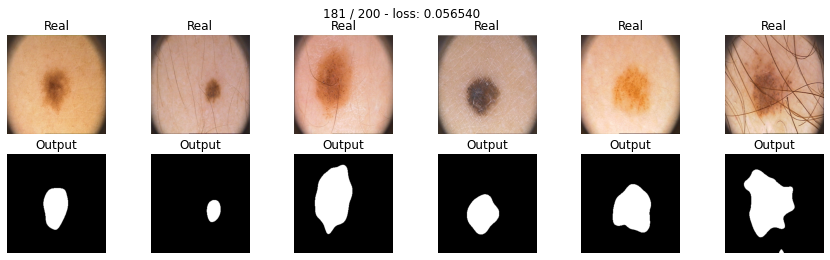

* Epoch 182/200
loss: 0.056188
* Epoch 183/200
loss: 0.055430
* Epoch 184/200
loss: 0.055674
* Epoch 185/200
loss: 0.056374
* Epoch 186/200
loss: 0.058382
* Epoch 187/200
loss: 0.057195
* Epoch 188/200
loss: 0.058085
* Epoch 189/200
loss: 0.056147
* Epoch 190/200
loss: 0.058155
* Epoch 191/200
loss: 0.056662
* Epoch 192/200
loss: 0.060917
* Epoch 193/200
loss: 0.056735
* Epoch 194/200
loss: 0.064300
* Epoch 195/200
loss: 0.060929
* Epoch 196/200
loss: 0.059860
* Epoch 197/200
loss: 0.056608
* Epoch 198/200
loss: 0.056222
* Epoch 199/200
loss: 0.058742
* Epoch 200/200
loss: 0.055780


In [109]:
segnet_tversky_acc = []
segnet_tversky_loss = []
tversky_model = SegNet().to(device)
max_epochs = 200
optimaizer = torch.optim.Adam(tversky_model.parameters(), lr = 3e-4)
train(tversky_model, optimaizer, tversky_loss, max_epochs, data_tr, data_val, 10)

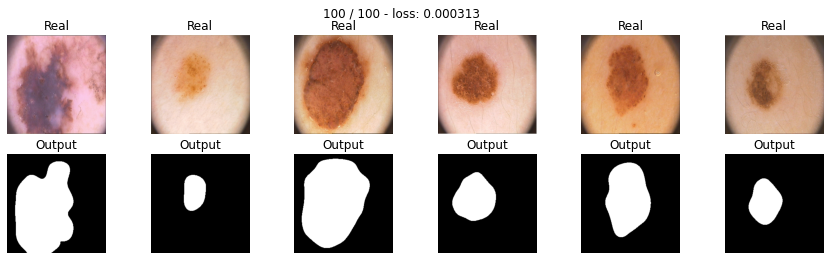

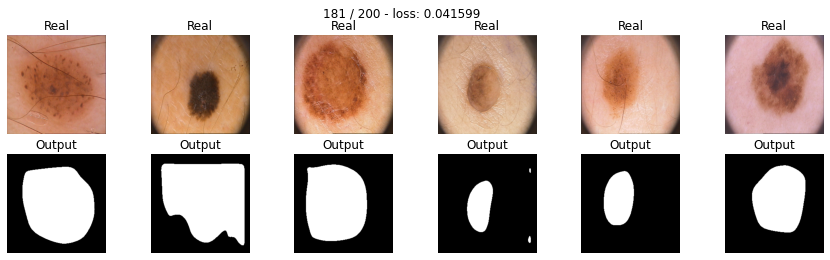

* Epoch 182/200
loss: 0.041599
* Epoch 183/200
loss: 0.041599
* Epoch 184/200
loss: 0.041598
* Epoch 185/200
loss: 0.041598
* Epoch 186/200
loss: 0.041598
* Epoch 187/200
loss: 0.041598
* Epoch 188/200
loss: 0.041598
* Epoch 189/200
loss: 0.041598
* Epoch 190/200
loss: 0.041598
* Epoch 191/200
loss: 0.041598
* Epoch 192/200
loss: 0.041598
* Epoch 193/200
loss: 0.041598
* Epoch 194/200
loss: 0.041598
* Epoch 195/200
loss: 0.041598
* Epoch 196/200
loss: 0.041598
* Epoch 197/200
loss: 0.041598
* Epoch 198/200
loss: 0.041598
* Epoch 199/200
loss: 0.041598
* Epoch 200/200
loss: 0.041598


In [121]:
unet_tversky_loss = []
unet_tversky_acc = []
tversky_model = UNet().to(device)
max_epochs = 200
optimaizer = torch.optim.Adam(tversky_model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(tversky_model, optimaizer, tversky_loss, max_epochs, data_tr, data_val, 11)

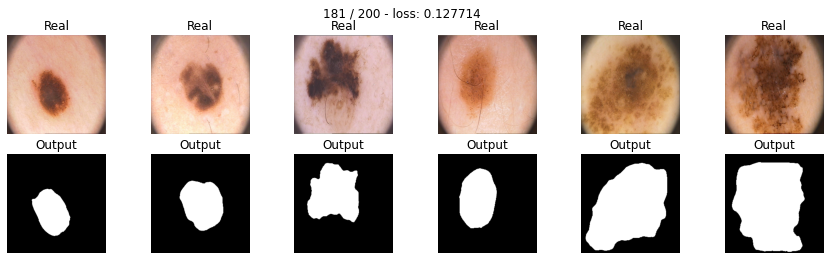

* Epoch 182/200
loss: 0.127714
* Epoch 183/200
loss: 0.127714
* Epoch 184/200
loss: 0.127714
* Epoch 185/200
loss: 0.127714
* Epoch 186/200
loss: 0.127714
* Epoch 187/200
loss: 0.127714
* Epoch 188/200
loss: 0.127714
* Epoch 189/200
loss: 0.127714
* Epoch 190/200
loss: 0.127714
* Epoch 191/200
loss: 0.127714
* Epoch 192/200
loss: 0.127714
* Epoch 193/200
loss: 0.127714
* Epoch 194/200
loss: 0.127714
* Epoch 195/200
loss: 0.127714
* Epoch 196/200
loss: 0.127714
* Epoch 197/200
loss: 0.127714
* Epoch 198/200
loss: 0.127714
* Epoch 199/200
loss: 0.127714
* Epoch 200/200
loss: 0.127714


In [111]:
unet2_tversky_loss = []
unet2_tversky_acc = []
tversky_model = UNet2().to(device)
max_epochs = 200
optimaizer = torch.optim.Adam(tversky_model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)
train(tversky_model, optimaizer, tversky_loss, max_epochs, data_tr, data_val, 12)

In [0]:
score_model(tversky_model, iou_pytorch, data_val)

0.4780000001192093

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

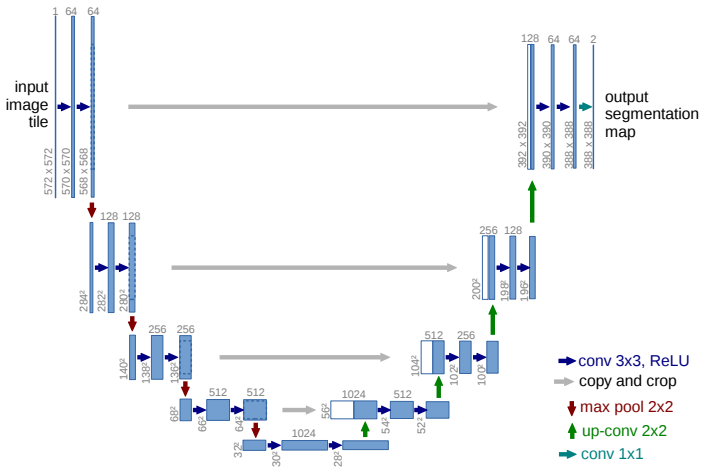

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
torch.cuda.empty_cache()

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.enc_conv0_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.enc_conv0_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.enc_conv0_3_dop = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size=2)  # 256 -> 128

        self.enc_conv1_0 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.enc_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.enc_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64

        self.enc_conv2_0 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.enc_conv2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.enc_conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32

        self.enc_conv3_0 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.enc_conv3_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.enc_conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0_0 = nn.Conv2d(in_channels=256 + 256, out_channels=256, kernel_size=3, padding=1)
        self.dec_conv0_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.dec_conv0_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 32 -> 64
        self.dec_conv1_0 = nn.Conv2d(in_channels=128 + 128, out_channels=128, kernel_size=3, padding=1)
        self.dec_conv1_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2_0 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_conv2_1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3_0 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv3_1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.dec_conv3_2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        # encoder
        e0_0 = F.relu(self.enc_conv0_0(x.to(device)))
        e0_1 = F.relu(self.enc_conv0_1(e0_0)) 
        e0_2 = F.relu(self.enc_conv0_2(e0_1))#256 -> 128
        e0_3 = self.pool0(e0_2)
        e1_0 = F.relu(self.enc_conv1_0(e0_3))#128 -> 64
        e1_1 = F.relu(self.enc_conv1_1(e1_0))
        e1_2 = F.relu(self.enc_conv1_2(e1_1))
        e1_3 = self.pool1(e1_2)
        e2_0 = F.relu(self.enc_conv2_0(e1_3)) #64->32
        e2_1 = F.relu(self.enc_conv2_1(e2_0))
        e2_2 = F.relu(self.enc_conv2_2(e2_1))
        e2_3 = self.pool2(e2_2)
        e3_0 = F.relu(self.enc_conv3_0(e2_3))#32->16
        e3_1 = F.relu(self.enc_conv3_1(e3_0))
        e3_2 = F.relu(self.enc_conv3_2(e3_1))
        e3_3 = self.pool3(e3_2)
        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_3))#16->16
        # decoder
        d0_0 = F.relu(self.dec_conv0_0(torch.cat((self.upsample0(b),e3_2), dim=1)))
        d0_1 = F.relu(self.dec_conv0_1(d0_0))#16->32
        d0_2 = F.relu(self.dec_conv0_2(d0_1))


        d1_0 = F.relu(self.dec_conv1_0(torch.cat((self.upsample1(d0_2),e2_2), dim=1)))
        d1_1 = F.relu(self.dec_conv1_1(d1_0))#32->64
        d1_2 = F.relu(self.dec_conv1_2(d1_1))
        
        d2_0 = F.relu(self.dec_conv2_0(torch.cat((self.upsample2(d1_2),e1_2), dim=1)))
        d2_1 = F.relu(self.dec_conv2_1(d2_0))
        d2_2 = F.relu(self.dec_conv2_2(d2_1))
        
        d3_0 = F.relu(self.dec_conv3_0(torch.cat((self.upsample3(d2_2),e0_2), dim=1)))
        d3_1 = F.relu(self.dec_conv3_1(d3_0))
        d3_2 = self.dec_conv3_2(d3_1)
        return d3_2

In [0]:
unet_model = UNet().to(device)
optimaizer = torch.optim.Adam(unet_model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)

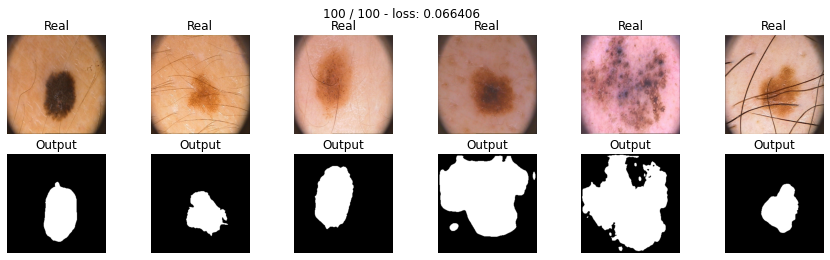

In [0]:
train(unet_model, optimaizer, dice_loss, 200, data_tr, data_val, 2)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

0.6620000243186951

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.enc_conv0_1 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.enc_conv0_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)#nn.MaxPool2d(kernel_size=2)  # 256 -> 128

        self.enc_conv1_0 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.enc_conv1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.enc_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2_0 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.enc_conv2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.enc_conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)# 64 -> 32

        self.enc_conv3_0 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.enc_conv3_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.enc_conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, output_padding=1,  stride=2) #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0_0 = nn.Conv2d(in_channels=256 + 256, out_channels=256, kernel_size=3, padding=1)
        self.dec_conv0_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.dec_conv0_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, output_padding=1, stride=2) #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 32 -> 64
        self.dec_conv1_0 = nn.Conv2d(in_channels=128 + 128, out_channels=128, kernel_size=3, padding=1)
        self.dec_conv1_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, output_padding=1, stride=2) #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2_0 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.dec_conv2_1 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, output_padding=1, stride=2) #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3_0 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.dec_conv3_1 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.dec_conv3_2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        # encoder
        e0_0 = F.relu(self.enc_conv0_0(x.to(device)))
        e0_1 = F.relu(self.enc_conv0_1(e0_0)) 
        e0_2 = F.relu(self.enc_conv0_2(e0_1))#256 -> 128
        e0_3 = self.pool0(e0_2)
        e1_0 = F.relu(self.enc_conv1_0(e0_3))#128 -> 64
        e1_1 = F.relu(self.enc_conv1_1(e1_0))
        e1_2 = F.relu(self.enc_conv1_2(e1_1))
        e1_3 = self.pool1(e1_2)
        e2_0 = F.relu(self.enc_conv2_0(e1_3)) #64->32
        e2_1 = F.relu(self.enc_conv2_1(e2_0))
        e2_2 = F.relu(self.enc_conv2_2(e2_1))
        e2_3 = self.pool2(e2_2)
        e3_0 = F.relu(self.enc_conv3_0(e2_3))#32->16
        e3_1 = F.relu(self.enc_conv3_1(e3_0))
        e3_2 = F.relu(self.enc_conv3_2(e3_1))
        e3_3 = self.pool3(e3_2)
        # bottleneck
        b = F.relu(self.bottleneck_conv(e3_3))#16->16
        # decoder
       # print(b.shape, e3_2.shape)
        d0_0 = F.relu(self.dec_conv0_0(torch.cat((self.upsample0(b),e3_2), dim=1)))
        d0_1 = F.relu(self.dec_conv0_1(d0_0))#16->32
        d0_2 = F.relu(self.dec_conv0_2(d0_1))


        d1_0 = F.relu(self.dec_conv1_0(torch.cat((self.upsample1(d0_2),e2_2), dim=1)))
        d1_1 = F.relu(self.dec_conv1_1(d1_0))#32->64
        d1_2 = F.relu(self.dec_conv1_2(d1_1))
        
        d2_0 = F.relu(self.dec_conv2_0(torch.cat((self.upsample2(d1_2),e1_2), dim=1)))
        d2_1 = F.relu(self.dec_conv2_1(d2_0))
        d2_2 = F.relu(self.dec_conv2_2(d2_1))
        
        d3_0 = F.relu(self.dec_conv3_0(torch.cat((self.upsample3(d2_2),e0_2), dim=1)))
        d3_1 = F.relu(self.dec_conv3_1(d3_0))
        d3_2 = self.dec_conv3_2(d3_1)
        return d3_2

In [0]:
unet2_focal_loss = []
unet2_focal_acc = []
unet2_model = UNet2().to(device)
optimaizer = torch.optim.Adam(unet2_model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)

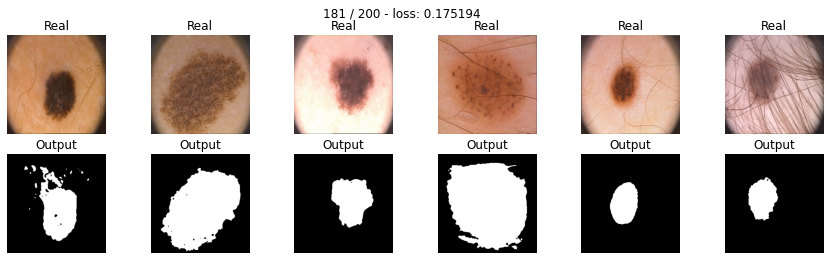

* Epoch 182/200
loss: 0.175194
* Epoch 183/200
loss: 0.175194
* Epoch 184/200
loss: 0.175194
* Epoch 185/200
loss: 0.175194
* Epoch 186/200
loss: 0.175194
* Epoch 187/200
loss: 0.175194
* Epoch 188/200
loss: 0.175194
* Epoch 189/200
loss: 0.175194
* Epoch 190/200
loss: 0.175194
* Epoch 191/200
loss: 0.175194
* Epoch 192/200
loss: 0.175194
* Epoch 193/200
loss: 0.175194
* Epoch 194/200
loss: 0.175194
* Epoch 195/200
loss: 0.175194
* Epoch 196/200
loss: 0.175194
* Epoch 197/200
loss: 0.175194
* Epoch 198/200
loss: 0.175194
* Epoch 199/200
loss: 0.175194
* Epoch 200/200
loss: 0.175194


In [102]:
train(unet2_model, optimaizer, focal_loss, 200, data_tr, data_val, 9)

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.



##Нерабочий код:

In [0]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()
          # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool0 =  nn.MaxPool2d(kernel_size=2)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16 ////18

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=130, dilation=2, stride=1) #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)     # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=66, dilation=2, stride=1)# nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)# 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=34, dilation=2, stride=1) #nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=18, dilation=2, stride=1)#nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x.to(device))))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))
        print(e3.shape)
        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        print(d3.shape)
        return d3

In [0]:
model_dilated = DilatedSegNet().to(device)
optimaizer = torch.optim.Adam(model_dilated.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=10, gamma=0.5)

In [0]:
train(model_dilated, optimaizer, bce_loss, 20, data_tr, data_val)

* Epoch 1/20
torch.Size([10, 256, 16, 16])


RuntimeError: ignored

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



**Отобразим графики функций потерь:**

In [0]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

1) SegNet:

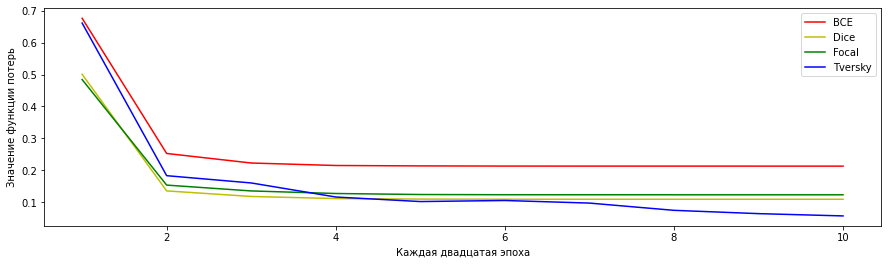

In [113]:
plot, ax = plt.subplots()
ax.plot(x, segnet_bce_loss, 'r', label='BCE')

ax.plot(x, segnet_dice_loss, 'y', label='Dice')
ax.plot(x, segnet_focal_loss, 'g', label='Focal')
ax.plot(x, segnet_tversky_loss, 'b', label='Tversky')
ax.set_xlabel('Каждая двадцатая эпоха')
ax.set_ylabel('Значение функции потерь')
ax.legend()

2) UNet:

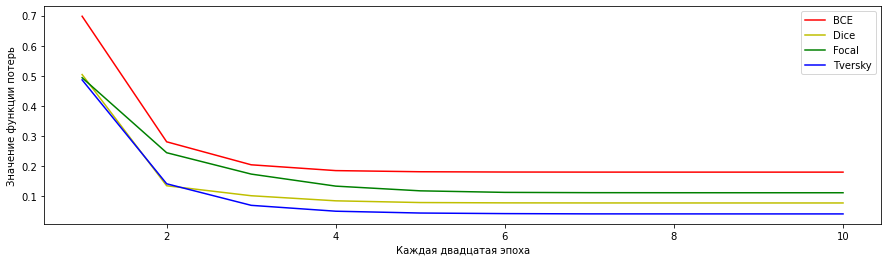

In [122]:
plot, ax = plt.subplots()
ax.plot(x, unet_bce_loss, 'r', label='BCE')
ax.plot(x, unet_dice_loss, 'y', label='Dice')
ax.plot(x, unet_focal_loss, 'g', label='Focal')
ax.plot(x, unet_tversky_loss, 'b', label='Tversky')
ax.set_xlabel('Каждая двадцатая эпоха')
ax.set_ylabel('Значение функции потерь')
ax.legend()

3) Unet2:

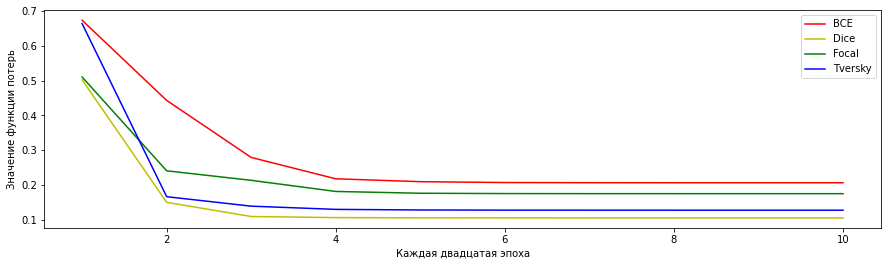

In [116]:
plot, ax = plt.subplots()
ax.plot(x, unet2_bce_loss, 'r', label='BCE')
ax.plot(x, unet2_dice_loss, 'y', label='Dice')
ax.plot(x, unet2_focal_loss, 'g', label='Focal')
ax.plot(x, unet2_tversky_loss, 'b', label='Tversky')
ax.set_xlabel('Каждая двадцатая эпоха')
ax.set_ylabel('Значение функции потерь')
ax.legend()

**Отобразим графики качества:**

1) Segnet:

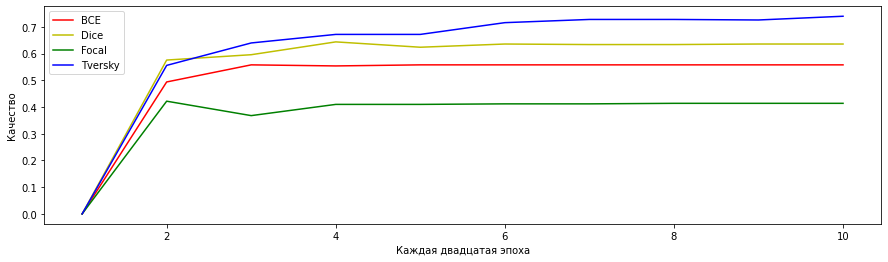

In [117]:
plot, ax = plt.subplots()
ax.plot(x, segnet_bce_acc, 'r', label='BCE')
ax.plot(x, segnet_dice_acc, 'y', label='Dice')
ax.plot(x, segnet_focal_acc, 'g', label='Focal')
ax.plot(x, segnet_tversky_acc, 'b', label='Tversky')
ax.set_xlabel('Каждая двадцатая эпоха')
ax.set_ylabel('Качество')
ax.legend()

2) UNet:

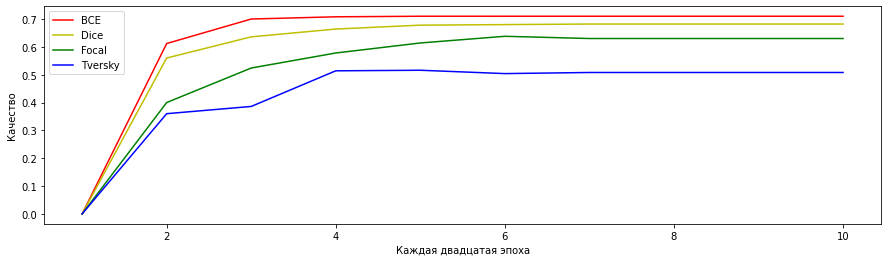

In [123]:
plot, ax = plt.subplots()
ax.plot(x, unet_bce_acc, 'r', label='BCE')
ax.plot(x, unet_dice_acc, 'y', label='Dice')
ax.plot(x, unet_focal_acc, 'g', label='Focal')
ax.plot(x, unet_tversky_acc, 'b', label='Tversky')
ax.set_xlabel('Каждая двадцатая эпоха')
ax.set_ylabel('Качество')
ax.legend()

Unet2:

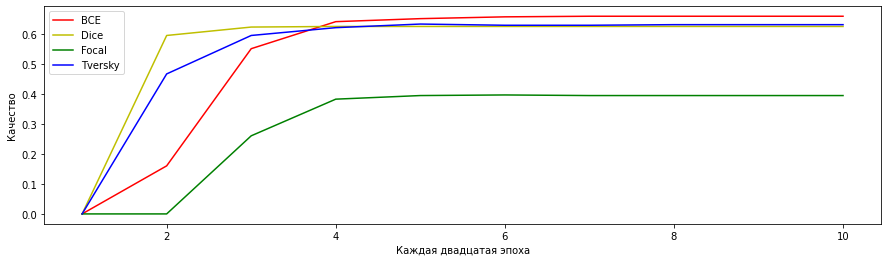

In [119]:
plot, ax = plt.subplots()
ax.plot(x, unet2_bce_acc, 'r', label='BCE')
ax.plot(x, unet2_dice_acc, 'y', label='Dice')
ax.plot(x, unet2_focal_acc, 'g', label='Focal')
ax.plot(x, unet2_tversky_acc, 'b', label='Tversky')
ax.set_xlabel('Каждая двадцатая эпоха')
ax.set_ylabel('Качество')
ax.legend()

**Вывод по графикам:**

Заметим по графикам, что лучшее качество дает Unet+BCE. У Focal в среднем качество хуже, чем остальные функции потерь. Неудачу Focal можно объяснить тем, что у нас не нестабильные классы(как правило в нашем случае фона не сильно больше, чем невуса) и на нашем датасете нет необходимости решать проблему, для которой была создана эта функция потерь.

Можно заметить, что нам хватает BCELoss при мощной архитектуре, а на более простой отлично работает TverskyLoss.Также можно заметить, что Tversky Loss быстрее приближается к локальному минимуму. 

В данном случае оптимальнее всего бы было использование SegNet + TverskyLoss, т.к по качеству оно сравнимо с UNet+BCELoss, но требует меньшее количество вычислительных ресурсов. 

Также из-за простой архитектуры SegNet продолжает учиться на 150+ архитектуре, в то время как остальные архитектуры после 100 эпохи не дают значительных улучшений качества/уменьшения функции потерь.

